In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


### En este notebook vamos a probar los word embeddings pero con la data de sarcasmo. Recuerda que la data de sacarmos la sacamos en json. 

In [0]:
import json
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Tenemos que sacar los hiperparámetros por buenas prácticas:
vocab_size = 10000
embedding_dim = 16
max_length = 32 #Esto me sirve para declarar el # máximo de números que quiero en mi lista (oracion)
#EL max_length es necesario dado que como lo pondré en unra red nn, necesito una estandarización del tamaño de inputs
trunc_type = 'post' #Cómo voy a truncar las oraciones que tengan más de 32 palabras
padding_type = 'post' #De qué forma voy a paddear
oov_tok = "<OOV>"
training_size = 20000

In [3]:
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
  -O /tmp/sarcasm.json

--2020-02-06 21:52:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.09s   

2020-02-06 21:52:16 (59.1 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
#Abrimos el archivo de sarcamos en json y lo leemos declarandolo como datastore
with open("/tmp/sarcasm.json","r") as f:
  datastore = json.load(f)

#Ahora, dividiremos ese archivo en json en diferentes listas... estas listas será las sgtes.
sentences = []
labels = []
urls = []
# Como la data está en json, voy a sacarla a listas para poder procesarla con mi Tokenizer
for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

In [0]:
# Ahora ya tengo mi data en listas, vamos a dividirla en oraciones de entrenamiento y de testeo

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

#Hasta acá ya tendría el equivalente a mi X_train, X_test, y_train, y_test
#Ahora, los voy a secuenciar y paddear.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

#Lo convierto a diccionario una vez tokenizado... con .word_index
word_index = tokenizer.word_index 

In [14]:
#Ahora, voy a crear las secuencias...
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_sequences[1:5]
#Como vemos, son las oraciones tokenizadas de acuerdo al word_index y en unas listas

[[4, 6840, 3096, 3097, 23, 2, 161, 1, 390, 2842, 6, 251, 9, 889],
 [153, 890, 2, 891, 1445, 2215, 595, 5650, 221, 133, 36, 45, 2, 8864],
 [1252, 38, 213, 382, 2, 1572, 29, 288, 23, 10, 2405, 1446, 5651, 958],
 [715, 672, 5652, 1043, 8865, 662, 553, 5, 4, 92, 1253, 90]]

In [0]:
#Ahora vamos a paddear estas tokenizaciones
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = 'post', truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,  maxlen = max_length, padding = 'post', truncating=trunc_type)

In [0]:
# Ahora toca hacer el modelo, entrenar a la red neuronal
"""
NOTA QUE:
La PRIMERA CAPA ES UN EMBEDDING, 
La SEGUNDA CAPA ES UN GLOBAL AVERAGE POOLING 1D,
De ahi viene la red neuronal.
"""

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Recuerda que el binary_crossentropy es porque estamos clasificando solo 2 clases.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
num_epochs = 30
# Al modelo entrenado es usual que le llamemos history. Luego de eso le pasaremos el método history para graficas sus métricas...
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 5s - loss: 0.5629 - accuracy: 0.7081 - val_loss: 0.4013 - val_accuracy: 0.8229
Epoch 2/30
20000/20000 - 3s - loss: 0.3117 - accuracy: 0.8737 - val_loss: 0.3508 - val_accuracy: 0.8478
Epoch 3/30
20000/20000 - 3s - loss: 0.2336 - accuracy: 0.9086 - val_loss: 0.3390 - val_accuracy: 0.8568
Epoch 4/30
20000/20000 - 3s - loss: 0.1884 - accuracy: 0.9280 - val_loss: 0.3571 - val_accuracy: 0.8536
Epoch 5/30
20000/20000 - 3s - loss: 0.1561 - accuracy: 0.9431 - val_loss: 0.3864 - val_accuracy: 0.8511
Epoch 6/30
20000/20000 - 3s - loss: 0.1325 - accuracy: 0.9536 - val_loss: 0.4144 - val_accuracy: 0.8511
Epoch 7/30
20000/20000 - 3s - loss: 0.1140 - accuracy: 0.9600 - val_loss: 0.4575 - val_accuracy: 0.8393
Epoch 8/30
20000/20000 - 3s - loss: 0.0979 - accuracy: 0.9673 - val_loss: 0.4895 - val_accuracy: 0.8419
Epoch 9/30
20000/20000 - 3s - loss: 0.0847 - accuracy: 0.9726 - val_loss: 0.5325 - val_accuracy: 0.8378
Epoch 10/30
200

### Vamos a plotear los resultados


In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epocas")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

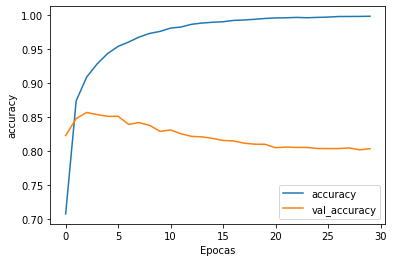

In [43]:
plot_graphs(history, "accuracy")

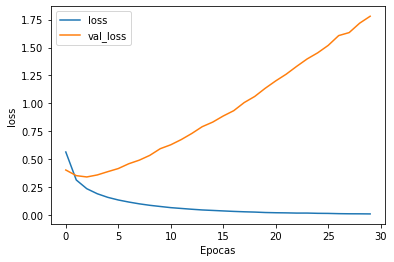

In [44]:
plot_graphs(history, "loss")


## Observamos principalmente que en el training, el accuracy sube hasta llegar casi a uno, pero en **la validacion** baja pareciendo mantenerse constante... 

## Por otro lado, en el loss, durante el entrenamiento baja, pero en la validación sube casi exponencialmente

## El objetivo sería probar con diferentes hiperparámetros, hasta que el % de accuracy sea de 90% y que el loss no suba de manera muy empinada...


In [45]:
model.predict_classes(testing_padded)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [46]:
testing_labels

array([1, 0, 0, ..., 0, 0, 0])